<a href="https://colab.research.google.com/github/s1173652/ProgrammingAssignment1/blob/main/BriannaCirillo_Programming1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programming Assignment: Numerical Optimization for Logistic Regression.

### Name: Brianna Cirillo


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Logistic/paper/logistic.pdf)

2. Read, complete, and run my code.

3. **Implement mini-batch SGD** and evaluate the performance.

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
    * Missing **the output after execution** will not be graded.
    
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo.  (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

6. On Canvas, submit the Google Drive/Dropbox/Github link to the HTML file.


## Grading criteria:

1. When computing the ```gradient``` and ```objective function value``` using a batch of samples, use **matrix-vector multiplication** rather than a FOR LOOP of **vector-vector multiplications**.

2. Plot ```objective function value``` against ```epochs```. In the plot, compare GD, SGD, and MB-SGD (with $b=8$ and $b=64$). The plot must look reasonable.

# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [ ]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('/diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [ ]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [ ]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[ 0.01617734 -0.04466687  0.10090361  0.07583519  0.07758121  0.0085555
  -0.1141719  -0.06977042]]
test std = 
[[0.97637919 0.86538312 0.92771655 1.0263836  1.09252646 1.11404664
  0.9464396  0.90138392]]


## 1.4. Add a dimension of all ones

In [ ]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


# 2. Logistic regression model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

In [ ]:
# Calculate the objective function value
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     objective function value (scalar)
def objective(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(-yxw) # n-by-1 matrix
    vec2 = numpy.log(1 + vec1) # n-by-1 matrix
    loss = numpy.mean(vec2) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    return loss + reg


In [ ]:
# initialize w
d = x_train.shape[1]
w = numpy.zeros((d, 1))

# evaluate the objective function value at w
lam = 1E-6
objval0 = objective(w, x_train, y_train, lam)
print('Initial objective function value = ' + str(objval0))

Initial objective function value = 0.6931471805599453


# 3. Numerical optimization

## 3.1. Gradient descent


The gradient at $w$ is $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [ ]:
# Calculate the gradient
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     g: g: d-by-1 matrix, full gradient
def gradient(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(yxw) # n-by-1 matrix
    vec2 = numpy.divide(yx, 1+vec1) # n-by-d matrix
    vec3 = -numpy.mean(vec2, axis=0).reshape(d, 1) # d-by-1 matrix
    g = vec3 + lam * w
    return g

In [ ]:
# Gradient descent for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_iter: integer, the maximal iterations
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: d-by-1 matrix, the solution
#     objvals: a record of each iteration's objective value
def grad_descent(x, y, lam, stepsize, max_iter=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_iter) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization

    for t in range(max_iter):
        objval = objective(w, x, y, lam)
        objvals[t] = objval
        print('Objective value at t=' + str(t) + ' is ' + str(objval))
        g = gradient(w, x, y, lam)
        w -= stepsize * g

    return w, objvals

Run gradient descent.

In [ ]:
lam = 1E-6
stepsize = 1.0
w, objvals_gd = grad_descent(x_train, y_train, lam, stepsize)

Objective value at t=0 is 0.6931471805599453
Objective value at t=1 is 0.5888879319200702
Objective value at t=2 is 0.546627611456874
Objective value at t=3 is 0.5240517087623151
Objective value at t=4 is 0.5100306644600322
Objective value at t=5 is 0.5005629725573313
Objective value at t=6 is 0.493831846342136
Objective value at t=7 is 0.4888770851972459
Objective value at t=8 is 0.4851367680071295
Objective value at t=9 is 0.4822580300149938
Objective value at t=10 is 0.4800078083291901
Objective value at t=11 is 0.4782262651091971
Objective value at t=12 is 0.4768005332592819
Objective value at t=13 is 0.4756490164697504
Objective value at t=14 is 0.4747115608646638
Objective value at t=15 is 0.4739430758871669
Objective value at t=16 is 0.4733092710589121
Objective value at t=17 is 0.47278373674753377
Objective value at t=18 is 0.4723459034505269
Objective value at t=19 is 0.47197958929675016
Objective value at t=20 is 0.4716719496050547
Objective value at t=21 is 0.471412706267658

## 3.2. Stochastic gradient descent (SGD)

Define $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [ ]:
# Calculate the objective Q_i and the gradient of Q_i
# Inputs:
#     w: d-by-1 matrix
#     xi: 1-by-d matrix
#     yi: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def stochastic_objective_gradient(w, xi, yi, lam):
    yx = yi * xi # 1-by-d matrix
    yxw = float(numpy.dot(yx, w)) # scalar

    # calculate objective function Q_i
    loss = numpy.log(1 + numpy.exp(-yxw)) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    obj = loss + reg

    # calculate stochastic gradient
    g_loss = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix
    g = g_loss + lam * w # d-by-1 matrix

    return obj, g

In [ ]:
# SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def sgd(x, y, lam, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization

    for t in range(max_epoch):
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]

        objval = 0 # accumulate the objective values
        for i in range(n):
            xi = x_rand[i, :] # 1-by-d matrix
            yi = float(y_rand[i, :]) # scalar
            obj, g = stochastic_objective_gradient(w, xi, yi, lam)
            objval += obj
            w -= stepsize * g

        stepsize *= 0.9 # decrease step size
        objval /= n
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))

    return w, objvals

Run SGD.

In [ ]:
lam = 1E-6
stepsize = 0.1
w, objvals_sgd = sgd(x_train, y_train, lam, stepsize)

<ipython-input-33-3ad5db498016>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yi = float(y_rand[i, :]) # scalar
<ipython-input-32-5a2d06aac09b>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yxw = float(numpy.dot(yx, w)) # scalar


Objective value at epoch t=0 is 0.5391909098577682
Objective value at epoch t=1 is 0.5151875955841052
Objective value at epoch t=2 is 0.5124347132232894
Objective value at epoch t=3 is 0.5089101069586296
Objective value at epoch t=4 is 0.5105564238367014
Objective value at epoch t=5 is 0.5049695860587697
Objective value at epoch t=6 is 0.49520361885454367
Objective value at epoch t=7 is 0.5031637439472869
Objective value at epoch t=8 is 0.4916114141156382
Objective value at epoch t=9 is 0.4910341210332951
Objective value at epoch t=10 is 0.48742228443169483
Objective value at epoch t=11 is 0.4860101748169082
Objective value at epoch t=12 is 0.48443862452723396
Objective value at epoch t=13 is 0.48703663517387447
Objective value at epoch t=14 is 0.48417965323104495
Objective value at epoch t=15 is 0.4821541138617308
Objective value at epoch t=16 is 0.47924066364519186
Objective value at epoch t=17 is 0.4806951936648117
Objective value at epoch t=18 is 0.4790702997616319
Objective value 

# 4. Compare GD with SGD

Plot objective function values against epochs.

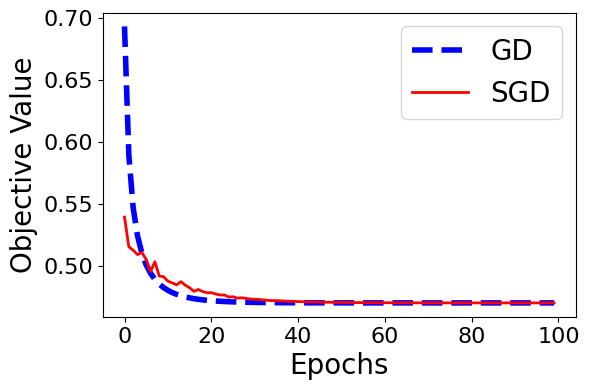

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', linewidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', linewidth=2)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Objective Value', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend([line0, line1], ['GD', 'SGD'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)

# 5. Prediction

In [ ]:
# Predict class label
# Inputs:
#     w: d-by-1 matrix
#     X: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    xw = numpy.dot(X, w)
    f = numpy.sign(xw)
    return f

In [ ]:
# evaluate training error
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

Training classification error is 0.2171875


In [ ]:
# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Test classification error is 0.2421875


# 6. Mini-batch SGD (fill the code)



## 6.1. Compute the objective $Q_I$ and its gradient using a batch of samples

Define $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [ ]:
# Calculate the objective Q_I and the gradient of Q_I
# Inputs:
#     w: d-by-1 matrix
#     xi: b-by-d matrix
#     yi: b-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def mb_stochastic_objective_gradient(w, xi, yi, lam, b):
    yxw = np.dot(xi, w)
    loss = numpy.log(1 + numpy.exp(np.multiply(-yi, yxw)))
    reg = lam / 2 * numpy.sum(w * w)
    obj = numpy.mean(loss) + reg
    gradient = -np.dot(xi.T, yi / (1 + numpy.exp(np.multiply(yi, yxw)))) / b
    g = gradient + lam * w

    return obj, g

## 6.2. Implement mini-batch SGD

Hints:
1. In every epoch, randomly permute the $n$ samples (just like SGD).
2. Each epoch has $\frac{n}{b}$ iterations. In every iteration, use $b$ samples, and compute the gradient and objective using the ``mb_stochastic_objective_gradient`` function. In the next iteration, use the next $b$ samples, and so on.


In [ ]:
# Mini-Batch SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def mb_sgd(x, y, lam, b, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    if w is None:
        w = numpy.zeros((d, 1))
    objvals = []

    for epoch in range(max_epoch):
        indices = numpy.random.permutation(n)
        x_shuffled = x[indices]
        y_shuffled = y[indices].reshape(-1, 1)

        epoch_obj_val = 0
        num_batches = n // b


        for i in range(num_batches):
            start = i * b
            end = start + b
            xi = x_shuffled[start:end]
            yi = y_shuffled[start:end]

            obj, gradient = mb_stochastic_objective_gradient(w, xi, yi, lam, b)
            w -= stepsize * gradient

            epoch_obj_val += obj

        # Record the objective value for this epoch
        epoch_obj_val /= num_batches
        objvals.append(epoch_obj_val)
        print(f'Epoch {epoch + 1}/{max_epoch}, Objective value: {objvals[-1]}')

    return w, objvals

## 6.3. Run MB-SGD

In [ ]:
# MB-SGD with batch size b=8
lam = 1E-6 # do not change
b = 8 # do not change
stepsize = 0.1 # you must tune this parameter

#w, objvals_mbsgd8 = mb_sgd(x_train, y_train, lam, b, stepsize)

best_stepsize = None
best_objval = float('inf')
best_w = None
max_epoch = 100

# Try different step sizes
for stepsize in [0.01, 0.05, 0.1, 0.5, 1.0]:
    print(f"Testing stepsize: {stepsize}")
    w, objvals = mb_sgd(x_train, y_train, lam, b, stepsize, max_epoch)
    final_objval = objvals[-1]
    if final_objval < best_objval:
        best_objval = final_objval
        best_stepsize = stepsize
        best_w = w

print(f"Best stepsize: {best_stepsize}, Best objective value: {best_objval}")

# Run the best step size again for final confirmation
w, objvals_mbsgd8 = mb_sgd(x_train, y_train, lam, b, best_stepsize, max_epoch)

Testing stepsize: 0.01
Epoch 1/100, Objective value: 0.6516254070084194
Epoch 2/100, Objective value: 0.5931432598587907
Epoch 3/100, Objective value: 0.5594023716582688
Epoch 4/100, Objective value: 0.5379177281707135
Epoch 5/100, Objective value: 0.52321896845279
Epoch 6/100, Objective value: 0.5128575464834142
Epoch 7/100, Objective value: 0.5049226647469003
Epoch 8/100, Objective value: 0.49887919087403987
Epoch 9/100, Objective value: 0.49416959028861374
Epoch 10/100, Objective value: 0.4903043261610768
Epoch 11/100, Objective value: 0.487278693167403
Epoch 12/100, Objective value: 0.48490747362830255
Epoch 13/100, Objective value: 0.48276134988910313
Epoch 14/100, Objective value: 0.48116843446983576
Epoch 15/100, Objective value: 0.4796330581068564
Epoch 16/100, Objective value: 0.47842784060939847
Epoch 17/100, Objective value: 0.4774332928641442
Epoch 18/100, Objective value: 0.4766213929828772
Epoch 19/100, Objective value: 0.47573277440351924
Epoch 20/100, Objective value: 0

Best stepsize: 0.01, Best objective value: 0.4708539725518707

In [ ]:
# MB-SGD with batch size b=64
lam = 1E-6 # do not change
b = 64 # do not change
stepsize = 0.1 # you must tune this parameter

# w, objvals_mbsgd64 = mb_sgd(x_train, y_train, lam, b, stepsize)

best_stepsize = None
best_objval = float('inf')
best_w = None
max_epoch = 100

# Try different step sizes
for stepsize in [0.01, 0.05, 0.1, 0.5, 1.0]:
    print(f"Testing stepsize: {stepsize}")
    w, objvals = mb_sgd(x_train, y_train, lam, b, stepsize, max_epoch)
    final_objval = objvals[-1]
    if final_objval < best_objval:
        best_objval = final_objval
        best_stepsize = stepsize
        best_w = w

print(f"Best stepsize: {best_stepsize}, Best objective value: {best_objval}")

# Run the best step size again for final confirmation
w, objvals_mbsgd64 = mb_sgd(x_train, y_train, lam, b, best_stepsize, max_epoch)

Testing stepsize: 0.01
Epoch 1/100, Objective value: 0.6875871802677537
Epoch 2/100, Objective value: 0.6754381294180992
Epoch 3/100, Objective value: 0.6642857811837903
Epoch 4/100, Objective value: 0.6539415793267636
Epoch 5/100, Objective value: 0.6443886727495609
Epoch 6/100, Objective value: 0.635641667070636
Epoch 7/100, Objective value: 0.6274660840250114
Epoch 8/100, Objective value: 0.6199092139856928
Epoch 9/100, Objective value: 0.6128842659405909
Epoch 10/100, Objective value: 0.6063597498268869
Epoch 11/100, Objective value: 0.6002732012056317
Epoch 12/100, Objective value: 0.5945976781354807
Epoch 13/100, Objective value: 0.5892601189889016
Epoch 14/100, Objective value: 0.5842734995534935
Epoch 15/100, Objective value: 0.579592778585724
Epoch 16/100, Objective value: 0.5752263632799643
Epoch 17/100, Objective value: 0.5711450079841595
Epoch 18/100, Objective value: 0.567224213015093
Epoch 19/100, Objective value: 0.563529730268428
Epoch 20/100, Objective value: 0.5601138

Best stepsize: 0.05, Best objective value: 0.4704903138656501

# 7. Plot and compare GD, SGD, and MB-SGD

You are required to compare the following algorithms:

- Gradient descent (GD)

- SGD

- MB-SGD with b=8

- MB-SGD with b=64

Follow the code in Section 4 to plot ```objective function value``` against ```epochs```. There should be four curves in the plot; each curve corresponds to one algorithm.

Hint: Logistic regression with $\ell_2$-norm regularization is a strongly convex optimization problem. All the algorithms will converge to the same solution. **In the end, the ``objective function value`` of the 4 algorithms will be the same. If not the same, your implementation must be wrong. Do NOT submit wrong code and wrong result!**

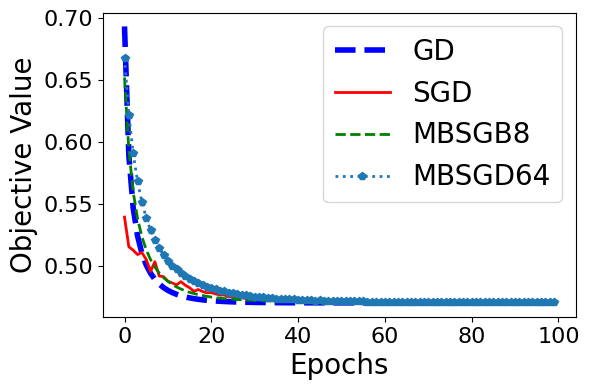

In [ ]:
# plot the 4 curves:
# 1. objective function value against epochs for GD
# 2. objective function value against epochs for SGD
# 3. objective function value against epochs for MB-SGD with b=8
# 4. objective function value against epochs for MB-SGD with b=64

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))
epochs_mbsgd8 = range(len(objvals_mbsgd8))
epochs_mbsgd64 = range(len(objvals_mbsgd64))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', linewidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', linewidth=2)
line2, = plt.plot(epochs_mbsgd8, objvals_mbsgd8, '--g', linewidth=2)
line3, = plt.plot(epochs_mbsgd64, objvals_mbsgd64, ':p', linewidth=2)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Objective Value', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend([line0, line1, line2, line3], ['GD', 'SGD', 'MBSGB8', 'MBSGD64'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)